<a href="https://colab.research.google.com/github/DanielWarfield1/MLWritingAndResearch/blob/main/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders
working through autoencoders, variational autoencoders, and disentangled variational autoencoders.

## Simple Autoencoder

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 42.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.8MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.41MB/s]


In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded.view(x.size(0), 1, 28, 28)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [4]:
num_epochs = 5
for epoch in range(num_epochs):
    for img, _ in train_loader:
        img = img.to(device)
        output = model(img)
        loss = criterion(output, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/5], Loss: 0.0351
Epoch [2/5], Loss: 0.0252
Epoch [3/5], Loss: 0.0226
Epoch [4/5], Loss: 0.0178
Epoch [5/5], Loss: 0.0173


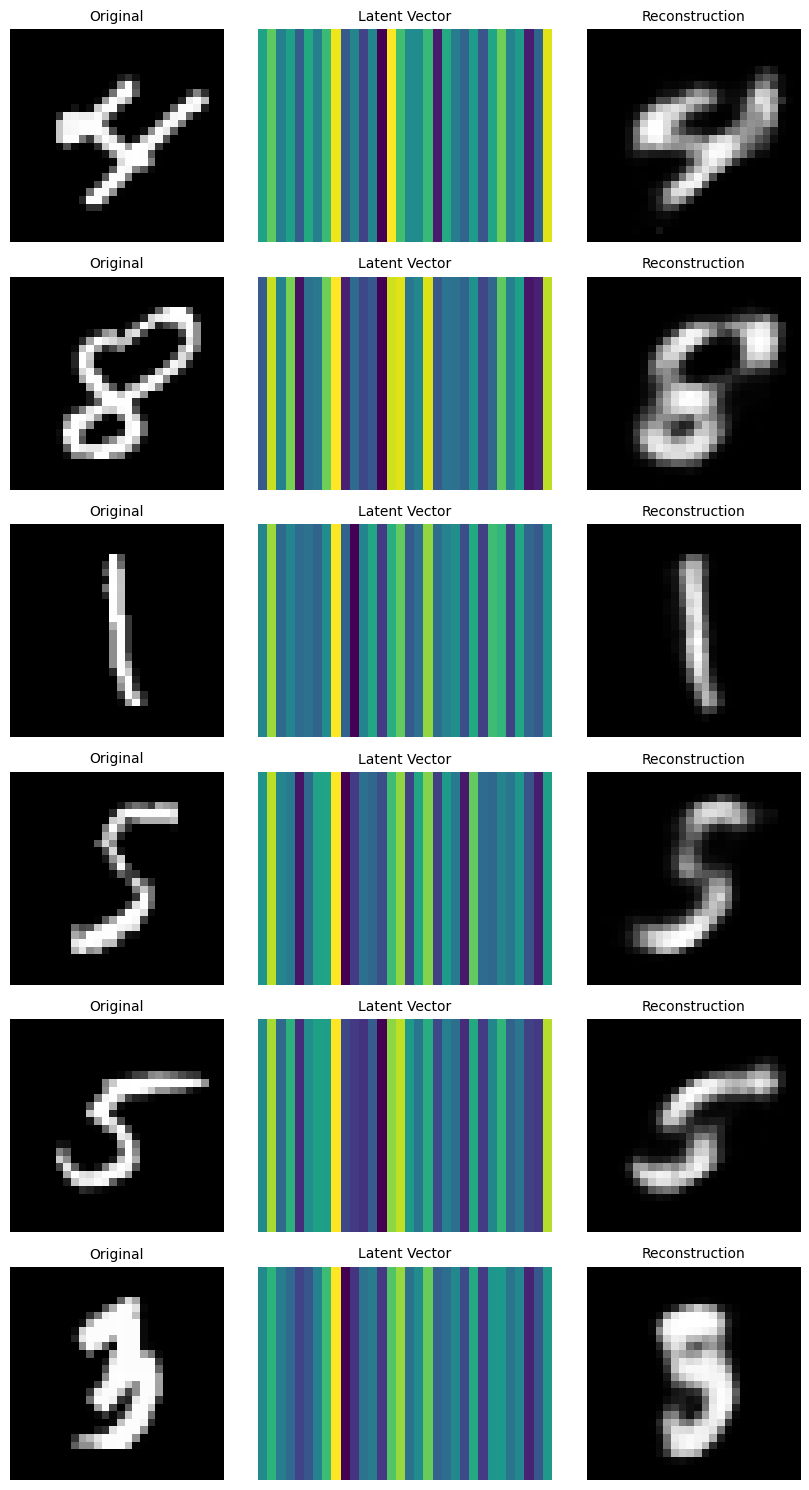

In [6]:
import matplotlib.pyplot as plt

# Set model to eval mode
model.eval()

# Choose n random examples
n = 6
examples = next(iter(DataLoader(train_dataset, batch_size=n, shuffle=True)))
images, _ = examples
images = images.to(device)

# Forward pass
with torch.no_grad():
    flat_images = images.view(images.size(0), -1)
    latents = model.encoder(flat_images)
    reconstructions = model.decoder(latents).view(-1, 1, 28, 28)

# Plot in a 3-column grid: Original | Latent | Reconstructed
fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(9, 2.5 * n))

for i in range(n):
    # Column 1: Original
    axes[i, 0].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[i, 0].set_title("Original", fontsize=10)
    axes[i, 0].axis('off')

    # Column 2: Latent representation as 1D heatmap
    axes[i, 1].imshow(latents[i].cpu().view(1, -1), cmap='viridis', aspect='auto')
    axes[i, 1].set_title("Latent Vector", fontsize=10)
    axes[i, 1].axis('off')

    # Column 3: Reconstructed
    axes[i, 2].imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
    axes[i, 2].set_title("Reconstruction", fontsize=10)
    axes[i, 2].axis('off')

# Shared y-label for readability
for ax in axes[:, 0]:
    ax.set_ylabel("Sample", fontsize=10)

plt.tight_layout()
plt.show()


# Denoising Autoencoder

In [7]:
# 1. Add noise function
def add_noise(inputs, noise_factor=0.5):
    noisy = inputs + noise_factor * torch.randn_like(inputs)
    return torch.clip(noisy, 0., 1.)  # Keep pixel values in [0,1]

# 2. Denoising training loop
num_epochs = 5
noise_factor = 0.5

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for img, _ in train_loader:
        img = img.to(device)
        noisy_img = add_noise(img, noise_factor=noise_factor)

        # Forward pass
        output = model(noisy_img)
        loss = criterion(output, img)  # Compare to clean target

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {avg_loss:.4f}")

[Epoch 1/5] Loss: 0.0258
[Epoch 2/5] Loss: 0.0231
[Epoch 3/5] Loss: 0.0223
[Epoch 4/5] Loss: 0.0216
[Epoch 5/5] Loss: 0.0211


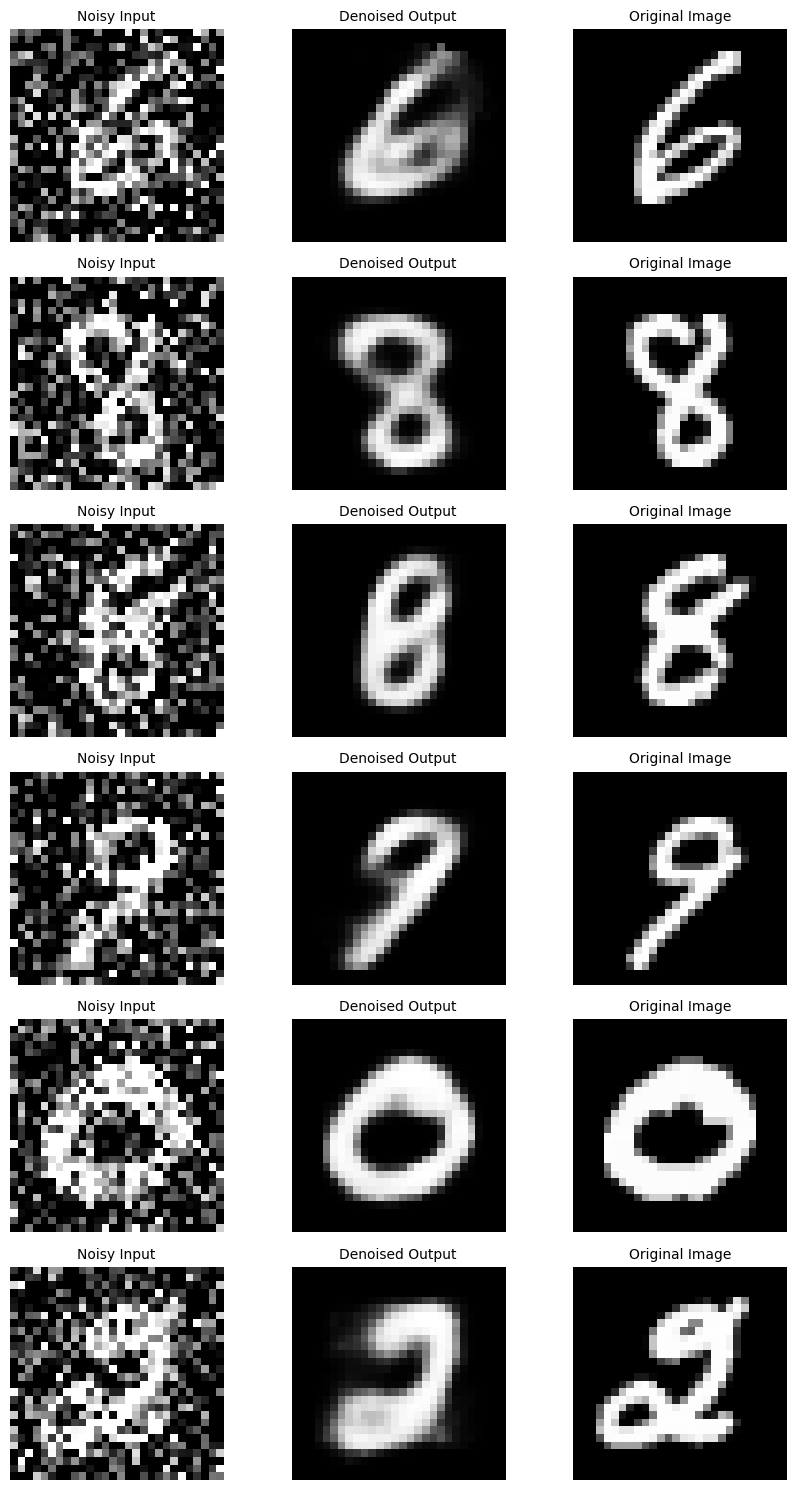

In [8]:
import matplotlib.pyplot as plt

# Set to evaluation mode
model.eval()

# Get n random samples
n = 6
examples = next(iter(DataLoader(train_dataset, batch_size=n, shuffle=True)))
images, _ = examples
images = images.to(device)

# Add noise
noisy_images = add_noise(images, noise_factor=0.5)

# Denoise
with torch.no_grad():
    denoised_images = model(noisy_images)

# Plot: Noisy → Denoised → Original
fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(9, 2.5 * n))

for i in range(n):
    # Noisy Input
    axes[i, 0].imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
    axes[i, 0].set_title("Noisy Input", fontsize=10)
    axes[i, 0].axis('off')

    # Denoised Output
    axes[i, 1].imshow(denoised_images[i].cpu().squeeze(), cmap='gray')
    axes[i, 1].set_title("Denoised Output", fontsize=10)
    axes[i, 1].axis('off')

    # Original Image
    axes[i, 2].imshow(images[i].cpu().squeeze(), cmap='gray')
    axes[i, 2].set_title("Original Image", fontsize=10)
    axes[i, 2].axis('off')

# Optionally save the figure for your blog
# plt.savefig("denoising_results.png", bbox_inches='tight', dpi=150)

plt.tight_layout()
plt.show()


# VAE

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Load MNIST
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define VAE Model
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder_core = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )
        self.fc_mu = nn.Linear(64, 32)
        self.fc_logvar = nn.Linear(64, 32)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.encoder_core(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded.view(x.size(0), 1, 28, 28), mu, logvar

# Loss Function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(x.size(0), -1), x.view(x.size(0), -1), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")


Epoch [1/10] Loss: 208.5782
Epoch [2/10] Loss: 163.4514
Epoch [3/10] Loss: 141.3980
Epoch [4/10] Loss: 130.1754
Epoch [5/10] Loss: 124.3398
Epoch [6/10] Loss: 120.9387
Epoch [7/10] Loss: 118.6614
Epoch [8/10] Loss: 117.0751
Epoch [9/10] Loss: 115.9068
Epoch [10/10] Loss: 114.8834


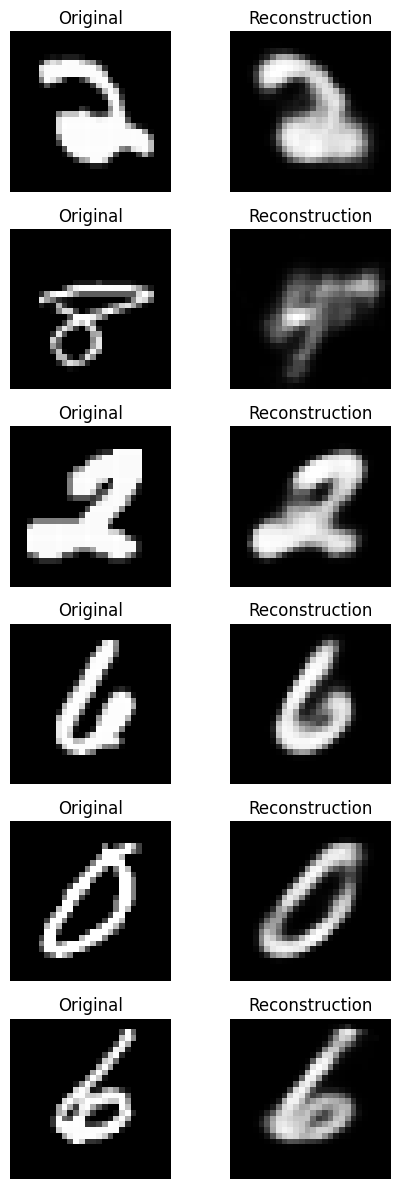

In [10]:
# Visualize n reconstructions
def visualize_vae_output(model, dataset, n=6):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=n, shuffle=True)
    imgs, _ = next(iter(dataloader))
    imgs = imgs.to(device)

    with torch.no_grad():
        recon, _, _ = model(imgs)

    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(5, 2 * n))
    for i in range(n):
        axes[i, 0].imshow(imgs[i].cpu().squeeze(), cmap='gray')
        axes[i, 0].set_title("Original")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(recon[i].cpu().squeeze(), cmap='gray')
        axes[i, 1].set_title("Reconstruction")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Call this after training
visualize_vae_output(model, train_dataset)


# VAE with manifold visualizaiton

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define VAE with 2D latent space
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder_core = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )
        self.fc_mu = nn.Linear(64, 2)       # 2D latent
        self.fc_logvar = nn.Linear(64, 2)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),               # match 2D latent
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.encoder_core(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded.view(x.size(0), 1, 28, 28), mu, logvar

# Loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x.view(x.size(0), -1), x.view(x.size(0), -1), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Train model
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")


Epoch [1/10] Loss: 206.6023
Epoch [2/10] Loss: 172.0120
Epoch [3/10] Loss: 166.1061
Epoch [4/10] Loss: 162.1677
Epoch [5/10] Loss: 158.4908
Epoch [6/10] Loss: 155.9316
Epoch [7/10] Loss: 154.1137
Epoch [8/10] Loss: 152.6065
Epoch [9/10] Loss: 151.3356
Epoch [10/10] Loss: 150.1631


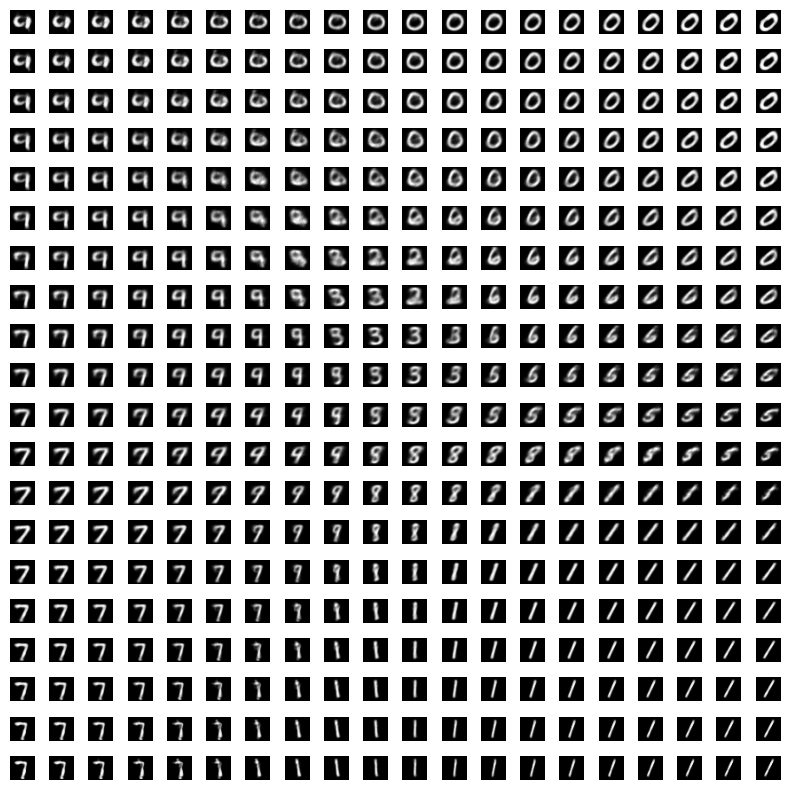

In [13]:
def plot_latent_manifold(model, grid_size=20, range_lim=3):
    model.eval()

    with torch.no_grad():
        # Create 2D grid of latent vectors
        z_grid = torch.tensor([
            [x, y]
            for y in np.linspace(-range_lim, range_lim, grid_size)
            for x in np.linspace(-range_lim, range_lim, grid_size)
        ], dtype=torch.float32).to(device)

        # Decode to images
        generated = model.decoder(z_grid).view(-1, 28, 28).cpu().numpy()

    # Plot grid of images
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(8, 8))
    for i in range(grid_size):
        for j in range(grid_size):
            ax = axes[i, j]
            ax.imshow(generated[i * grid_size + j], cmap="gray")
            ax.axis("off")
    plt.tight_layout()
    plt.show()

# After training, visualize manifold
plot_latent_manifold(model)


# B-VAE

In [3]:
latent_dim = 8

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

# Define Beta-VAE with 4D latent space
class BetaVAE(nn.Module):
    def __init__(self, latent_dim=4):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder_core = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True)
        )
        self.fc_mu = nn.Linear(64, latent_dim)
        self.fc_logvar = nn.Linear(64, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(x.size(0), -1)
        h = self.encoder_core(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded.view(x.size(0), 1, 28, 28), mu, logvar

# Loss function with beta
def beta_vae_loss(recon_x, x, mu, logvar, beta=4.0):
    recon_loss = F.binary_cross_entropy(recon_x.view(x.size(0), -1), x.view(x.size(0), -1), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_div



# Train model
model = BetaVAE(latent_dim=latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(imgs)
        loss = beta_vae_loss(recon, imgs, mu, logvar, beta=4.0)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_loss:.4f}")


Epoch [1/10] Loss: 213.1820
Epoch [2/10] Loss: 184.5511
Epoch [3/10] Loss: 171.3549
Epoch [4/10] Loss: 164.1854
Epoch [5/10] Loss: 159.4746
Epoch [6/10] Loss: 156.6514
Epoch [7/10] Loss: 155.0812
Epoch [8/10] Loss: 154.0088
Epoch [9/10] Loss: 152.9970
Epoch [10/10] Loss: 152.3330


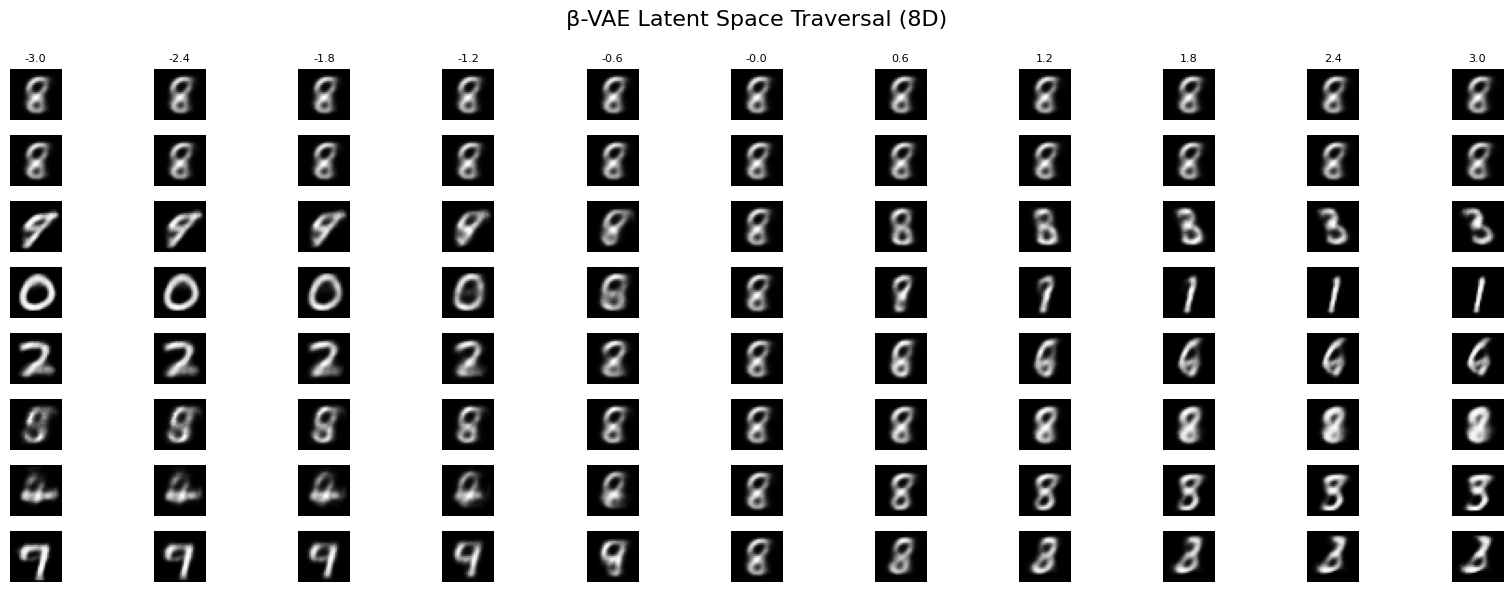

In [5]:
# Enhanced latent traversal visualization
import torch
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    steps = 11  # number of interpolation steps
    z_range = torch.linspace(-3, 3, steps).to(device)
    base_z = torch.zeros(1, latent_dim).to(device)

    fig, axes = plt.subplots(latent_dim, steps, figsize=(steps * 1.5, 6))

    for dim in range(latent_dim):  # for each latent dimension
        for i, val in enumerate(z_range):
            z_mod = base_z.clone()
            z_mod[0, dim] = val
            img = model.decoder(z_mod).view(28, 28).cpu().numpy()
            ax = axes[dim, i]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if dim == 0:
                ax.set_title(f"{val:.1f}", fontsize=8)

        axes[dim, 0].set_ylabel(f"z[{dim}]", rotation=0, labelpad=15, size=12, ha='right', va='center')

    plt.suptitle(f"β-VAE Latent Space Traversal ({latent_dim}D)", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()